In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate


In [7]:
import numpy
print(numpy.__version__)

import sys
print(sys.executable)


1.26.4
c:\Users\vlad2\intellipaat\epg-assignments\data_science\netflix_recommender\.venv\Scripts\python.exe


In [8]:
movies_df = pd.read_csv('dataset/movie_titles.csv',  encoding = 'ISO-8859-1', header = None, names = ['movie_id',"year","title"],usecols =[0,1,2])
#print(movies_df.info())
print(movies_df.head())

print("\nMissing values in Movies Dataset:")
print(movies_df.isnull().sum())

movies_df.drop_duplicates(inplace=True)



   movie_id    year                         title
0         1  2003.0               Dinosaur Planet
1         2  2004.0    Isle of Man TT 2004 Review
2         3  1997.0                     Character
3         4  1994.0  Paula Abdul's Get Up & Dance
4         5  2004.0      The Rise and Fall of ECW

Missing values in Movies Dataset:
movie_id    0
year        7
title       0
dtype: int64


In [26]:
ratings_df = pd.read_csv('dataset/combined_data_1.txt',header = None, names = ['cust_id', 'rating'], usecols = [0,1])
print(ratings_df.head())
print(ratings_df.tail())

print("\nMissing values in Ratings Dataset:")
print(ratings_df.isnull().sum())


ratings_df.drop_duplicates(inplace=True)
#lets create a new col with movie id


movie_id = None

movie_np = []

for i in ratings_df["cust_id"]:
  if ":" in i:
    movie_id = int(i.replace(":",''))
  movie_np.append(movie_id)

ratings_df['movie_id'] = movie_np

#print(ratings_df.head())


ratings_df = ratings_df[ratings_df['rating'].notna()]
ratings_df

   cust_id  rating
0       1:     NaN
1  1488844     3.0
2   822109     5.0
3   885013     4.0
4    30878     4.0
          cust_id  rating
24058258  2591364     2.0
24058259  1791000     2.0
24058260   512536     5.0
24058261   988963     3.0
24058262  1704416     3.0

Missing values in Ratings Dataset:
cust_id       0
rating     4499
dtype: int64


,cust_id,rating,movie_id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058156,438990,1.0,4499
24058162,1498503,2.0,4499
24058174,2541000,1.0,4499
24058179,1999441,2.0,4499


In [27]:
merged_df = pd.merge(ratings_df, movies_df, on='movie_id')
merged_df

,cust_id,rating,movie_id,year,title
0,1488844,3.0,1,2003.0,Dinosaur Planet
1,822109,5.0,1,2003.0,Dinosaur Planet
2,885013,4.0,1,2003.0,Dinosaur Planet
3,30878,4.0,1,2003.0,Dinosaur Planet
4,823519,3.0,1,2003.0,Dinosaur Planet
...,...,...,...,...,...
1819551,438990,1.0,4499,2002.0,In My Skin
1819552,1498503,2.0,4499,2002.0,In My Skin
1819553,2541000,1.0,4499,2002.0,In My Skin
1819554,1999441,2.0,4499,2002.0,In My Skin


      movie_id                                              title  rating
3900      3929  The Hammer Horror Series: Night Creatures / Th...     5.0
2520      2530                   The Man in the Gray Flannel Suit     5.0
2153      2157             John Carpenter: The Man and His Movies     5.0
3190      3211          Marmalade Boy: Ultimate Scrapbook: Vol. 3     5.0
1704      1706                                            Strings     5.0
...        ...                                                ...     ...
4089      4126                                         Vice Girls     1.0
3727      3754                                     The Navigators     1.0
2406      2415                                     Chains of Gold     1.0
3158      3179                          Bloodfist 5: Human Target     1.0
4282      4324                                          Net Games     1.0

[4453 rows x 3 columns]
rating
1.0    241379
2.0    330006
3.0    409361
4.0    428609
5.0    410201
Name: coun

C:\Users\vlad2\AppData\Local\Temp\ipykernel_28468\897417834.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


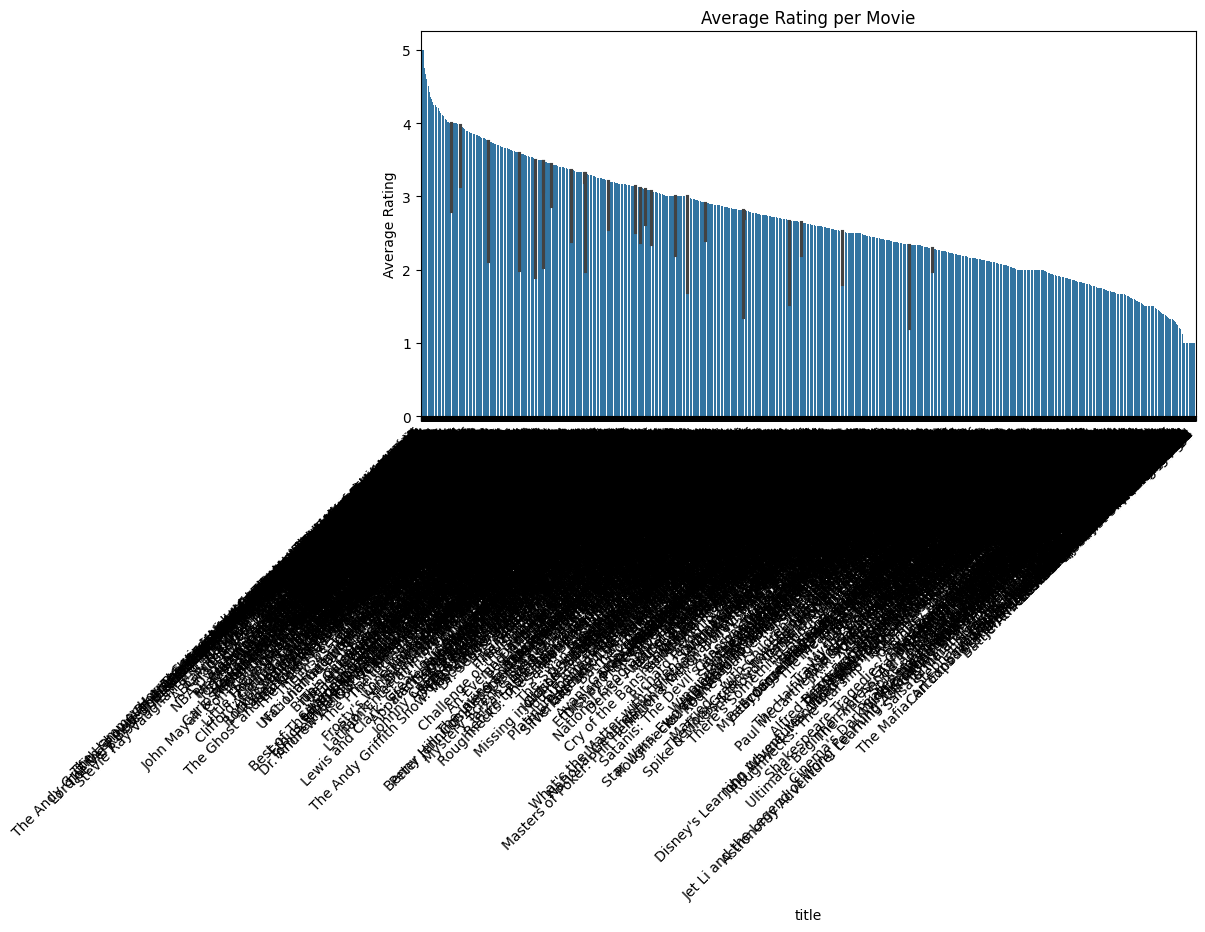

C:\Users\vlad2\AppData\Local\Temp\ipykernel_28468\897417834.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


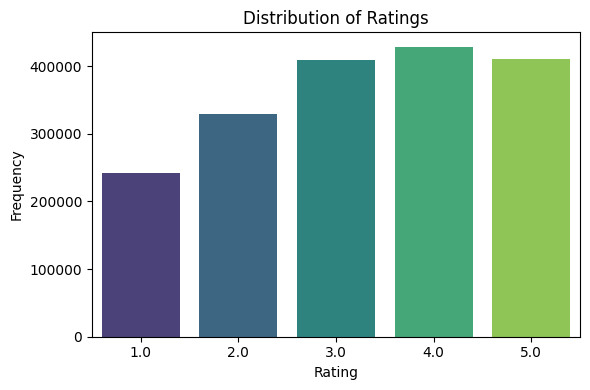

In [28]:
# Basic exploratory data analysis


# 1. Calculate average rating per movie
avg_ratings = merged_df.groupby(['movie_id', 'title'])['rating'].mean().reset_index()
avg_ratings = avg_ratings.sort_values(by='rating', ascending=False)
print(avg_ratings)

# 2. Rating distribution
rating_counts = merged_df['rating'].value_counts().sort_index()
print(rating_counts)
# 3. Plot: Average Ratings per Movie
plt.figure(figsize=(10, 5))
sns.barplot(data=avg_ratings, x='title', y='rating')
plt.title('Average Rating per Movie')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Plot: Rating Distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [35]:
#print(merged_df)
df = pd.DataFrame(merged_df)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['cust_id', 'movie_id', 'rating']], reader)

trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)

# Step 1: Get all ratings by customer 1488844
user_rated = df[df['cust_id'] == 1488844]
rated_movie_ids = user_rated['movie_id'].tolist()

# Step 2: Create a list of unrated movies
all_movie_ids = df['movie_id'].unique()
unrated_movie_ids = [m for m in all_movie_ids if m not in rated_movie_ids]

# Step 3: Predict ratings for all unrated movies
predictions = []
for movie_id in unrated_movie_ids:
    est = model.predict(1488844, movie_id).est
    predictions.append((movie_id, est))

# Step 4: Sort and display top predictions
predictions.sort(key=lambda x: x[1], reverse=True)


for movie_id, est in predictions:
    print(f"{movies_df.get(movie_id, movie_id)} → Predicted Rating: {est:.2f}")




1418 → Predicted Rating: 4.61
3456 → Predicted Rating: 4.60
13 → Predicted Rating: 4.58
1072 → Predicted Rating: 4.47
2114 → Predicted Rating: 4.42
325 → Predicted Rating: 4.42
2782 → Predicted Rating: 4.40
1476 → Predicted Rating: 4.38
2205 → Predicted Rating: 4.37
2019 → Predicted Rating: 4.36
724 → Predicted Rating: 4.36
1495 → Predicted Rating: 4.35
774 → Predicted Rating: 4.35
2162 → Predicted Rating: 4.34
33 → Predicted Rating: 4.33
135 → Predicted Rating: 4.31
1692 → Predicted Rating: 4.31
85 → Predicted Rating: 4.31
106 → Predicted Rating: 4.30
3962 → Predicted Rating: 4.30
2108 → Predicted Rating: 4.29
2803 → Predicted Rating: 4.29
4427 → Predicted Rating: 4.28
68 → Predicted Rating: 4.26
1587 → Predicted Rating: 4.26
2452 → Predicted Rating: 4.26
587 → Predicted Rating: 4.25
241 → Predicted Rating: 4.24
1110 → Predicted Rating: 4.24
595 → Predicted Rating: 4.23
37 → Predicted Rating: 4.23
2754 → Predicted Rating: 4.22
886 → Predicted Rating: 4.22
167 → Predicted Rating: 4.21
